In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Згенерувати множину точок нормального розподілу.

In [2]:
#S_cov = np.eye(3)


S_cov = np.array([[0.9, 0.6, 0.3],
 [0.6, 0.7,  0.1],
 [0.3, 0.1, 0.8]])
m_mean = np.array([1., 1., 1.])

d_diam = np.sqrt(0.1*S_cov.trace())
e_thresh = 0.01*d_diam

#d_diam = 2
#e_thresh = 0.1

In [3]:
S_cov, m_mean

(array([[0.9, 0.6, 0.3],
        [0.6, 0.7, 0.1],
        [0.3, 0.1, 0.8]]),
 array([1., 1., 1.]))

In [4]:
d_diam*d_diam + e_thresh*e_thresh, d_diam*d_diam - e_thresh*e_thresh

(0.24002400000000004, 0.23997600000000005)

Згенеруємо точки, обчислимо умову належності до еліпсоїда, відберемо по 1000 на кожен клас. Якщо якогось з класів менше тисячі, генеруємо вибірку більшого розміру

In [5]:
S_hat = np.linalg.inv(S_cov)
S_hat

array([[ 3.05555556, -2.5       , -0.83333333],
       [-2.5       ,  3.5       ,  0.5       ],
       [-0.83333333,  0.5       ,  1.5       ]])

In [6]:
size0=2000
is_inside=np.array([0])
is_outside=np.array([0])
while(True):
    if(is_inside.sum()>=1000 and is_outside.sum()>=1000):
        X_inside = np.array( X[is_inside][:1000] )
        X_outside = np.array( X[is_outside][:1000] )
        X = np.vstack([X_inside, X_outside])
        is_inside = np.array( [True]*1000 + [False]*1000)
        is_outside = np.array( [False]*1000 + [True]*1000)
        #X, is_inside, is_outside = shuffle(X, is_inside, is_outside)
        break
    else:
        #print(size0)
        X = np.random.multivariate_normal(mean=m_mean, cov=S_cov, size=size0)
        is_inside = [ (X[i]-m_mean).T @ S_hat @ (X[i]-m_mean) <= d_diam*d_diam - e_thresh*e_thresh for i in range(len(X)) ]        
        is_inside = np.array(is_inside).astype('bool')
        is_outside = [ (X[i]-m_mean).T @ S_hat @ (X[i]-m_mean) >= d_diam*d_diam + e_thresh*e_thresh for i in range(len(X)) ]        
        is_outside = np.array(is_outside).astype('bool')
        size0+=1000
        continue
X.shape, is_inside.shape, is_outside.shape
#X.shape

((2000, 3), (2000,), (2000,))

# Графік згенерованих даних в проекції xy

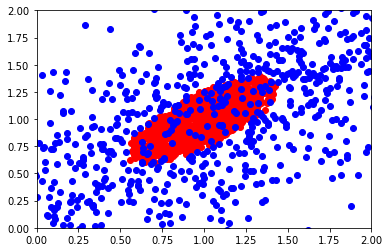

In [7]:
plt.xlim([0,2])
plt.ylim([0,2])
plt.scatter(X[is_inside][:,0], X[is_inside][:,1], color='red')
plt.scatter(X[is_outside][:,0], X[is_outside][:,1], color='blue')

Із координат [x,y,z] нам потрібно перейти у координати 2-го порядку, тобто [1, x,y,z, x2, xy,xz, y2, yz, z2]

In [8]:
def get_coord2order(vect):
    return np.array([1.0, vect[0], vect[1], vect[2], vect[0]*vect[0], vect[0]*vect[1], \
                     vect[0]*vect[2], vect[1]*vect[1], vect[1]*vect[2], vect[2]*vect[2] ])

X_second_order = [get_coord2order(X[i]) for i in range(len(X))]
X_second_order = np.vstack(X_second_order)

In [9]:
X_second_order = shuffle( np.vstack( [(-1)*X_second_order[is_inside],  X_second_order[is_outside] ]) )

# Власне, алгоритм Персептрона (у просторі розмірності 3*2+3+1 - координат другого порядку)

In [10]:
alpha0 = np.random.normal(loc = 0, scale = 1 , size=X_second_order[0].shape) #початкове наближення
alpha = alpha0

(X_second_order.dot(alpha0)<=0).sum() #обьектів, що по неправильний бік від площини

1209

it=10000, n_wrong = 502
it=20000, n_wrong = 17


<ipython-input-11-b8b5977bb270>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


it=30000, n_wrong = 197
it=40000, n_wrong = 39
it=50000, n_wrong = 385
it=60000, n_wrong = 16
it=70000, n_wrong = 12


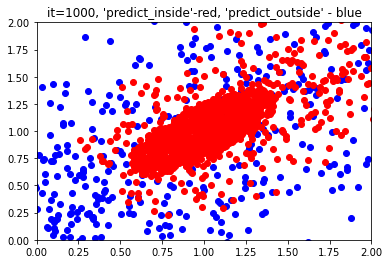

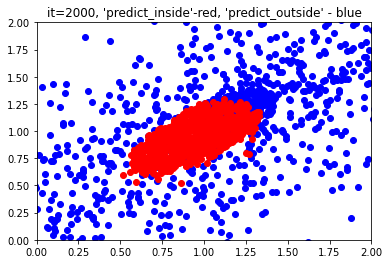

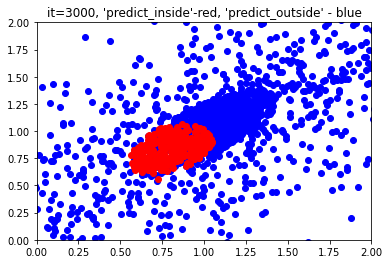

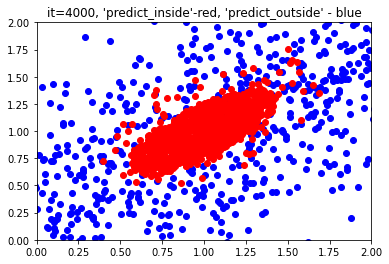

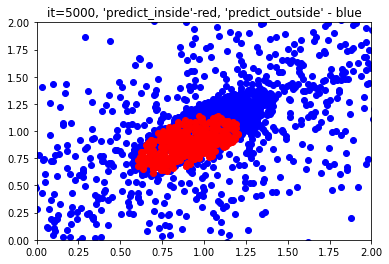

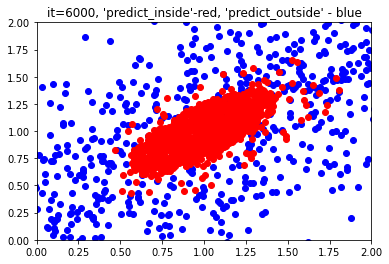

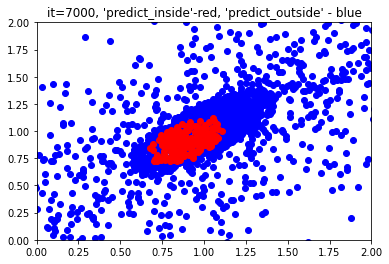

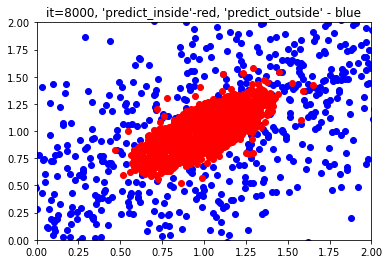

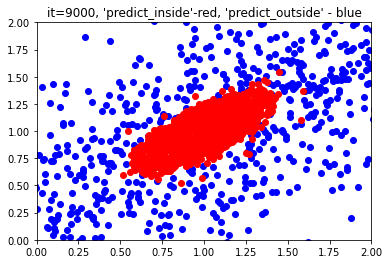

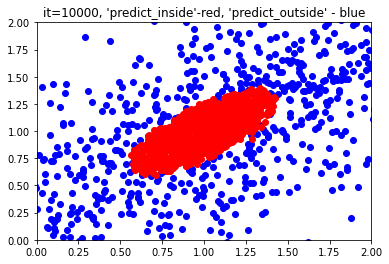

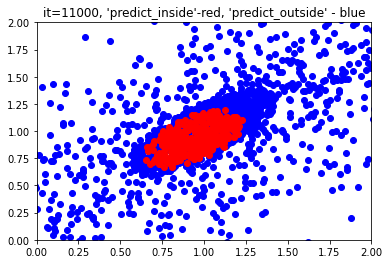

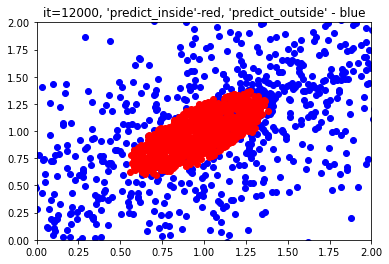

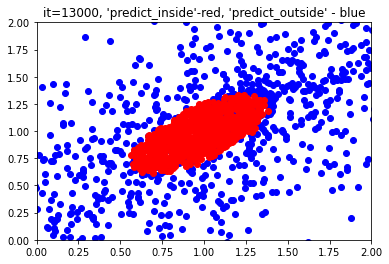

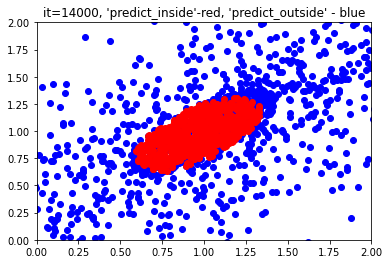

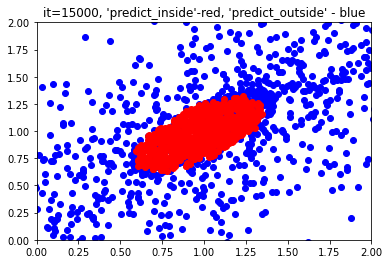

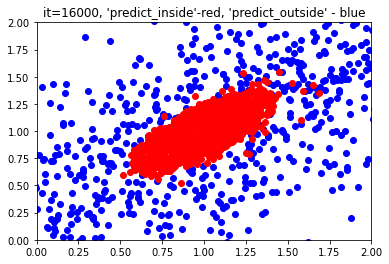

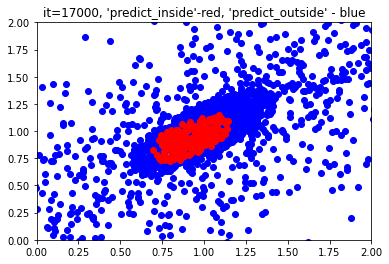

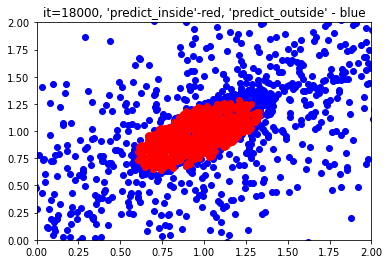

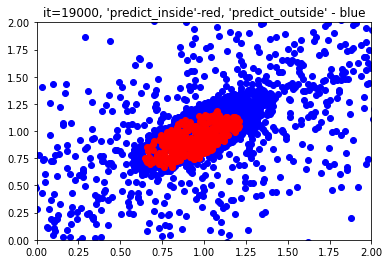

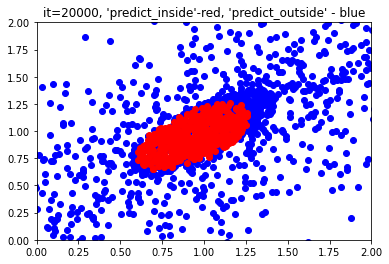

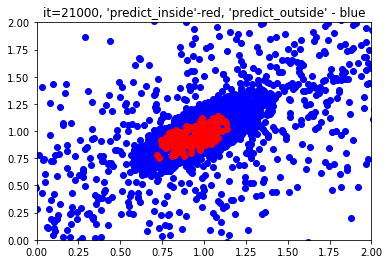

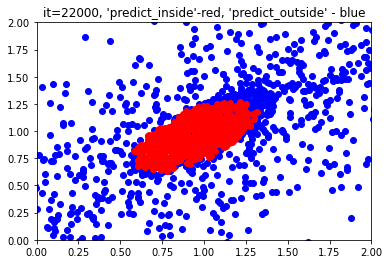

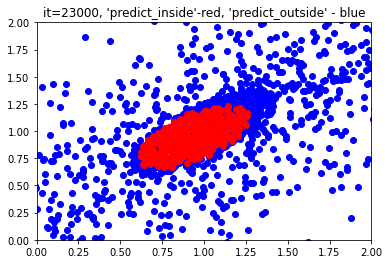

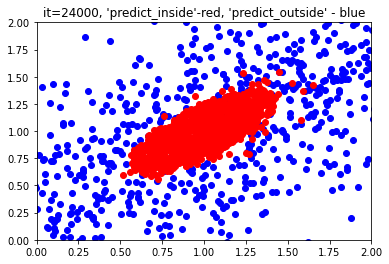

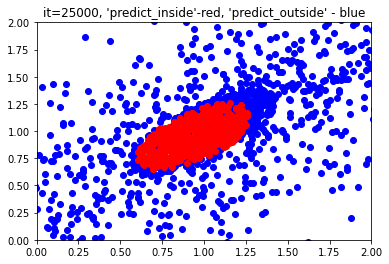

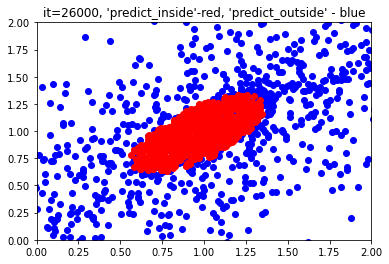

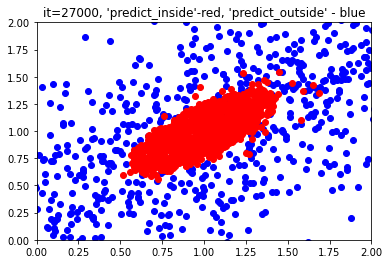

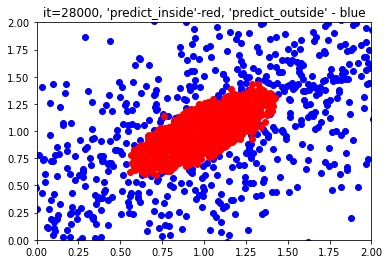

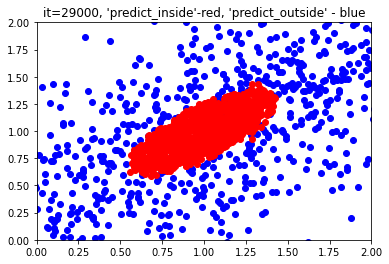

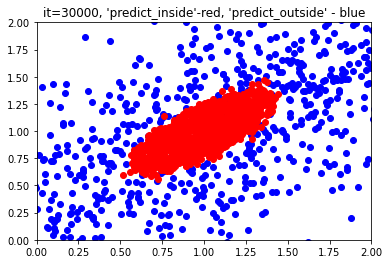

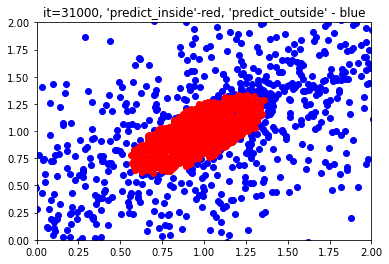

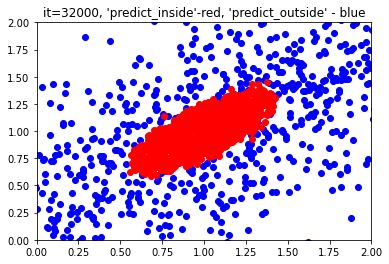

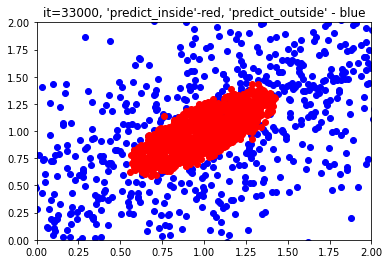

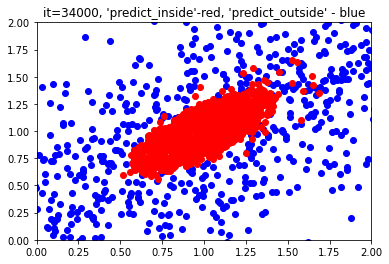

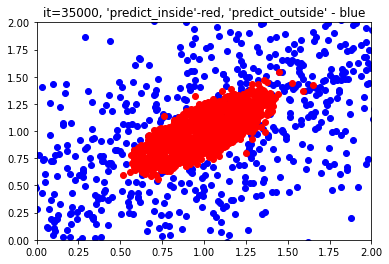

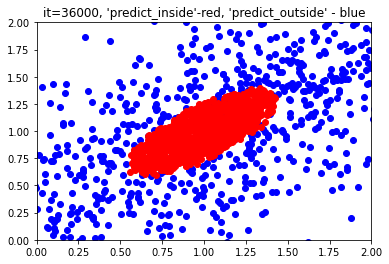

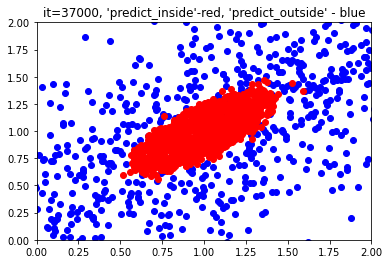

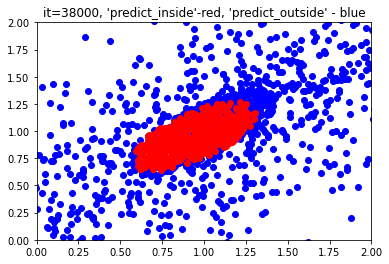

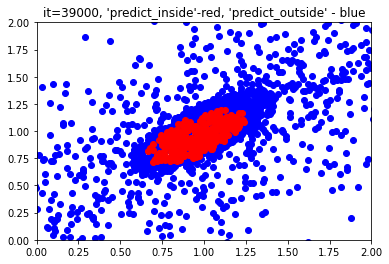

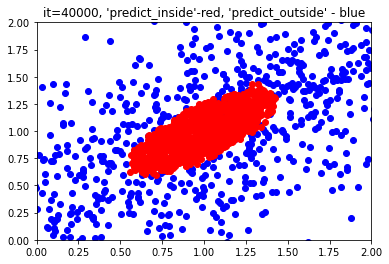

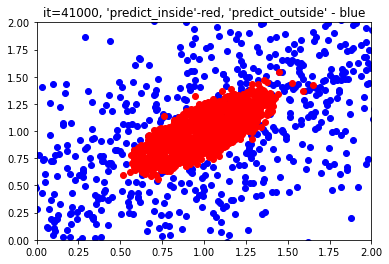

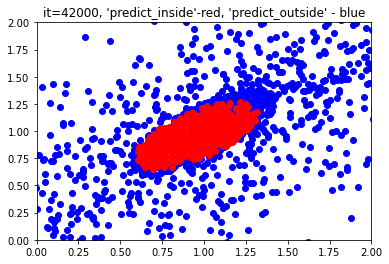

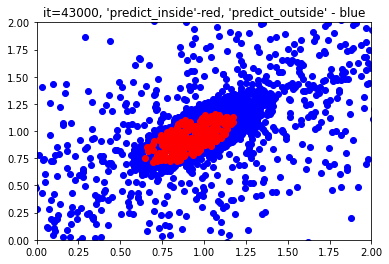

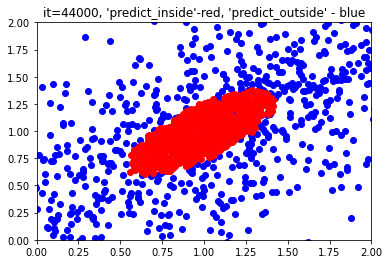

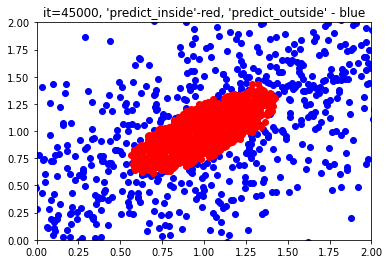

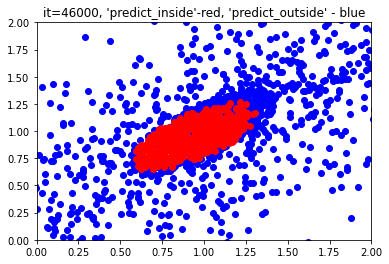

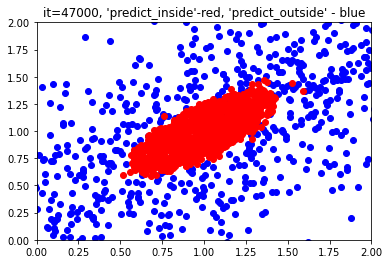

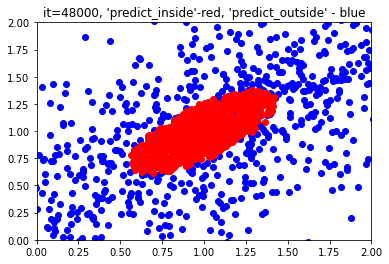

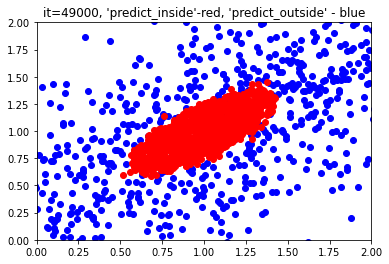

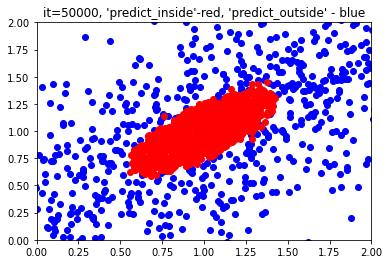

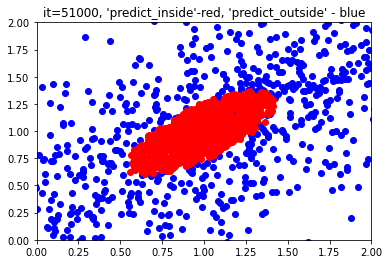

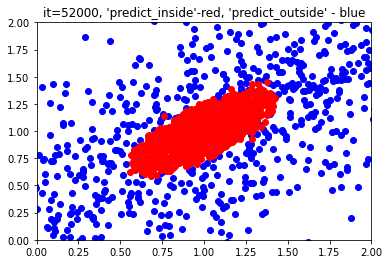

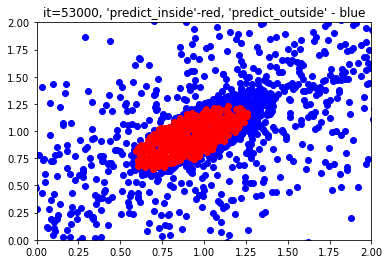

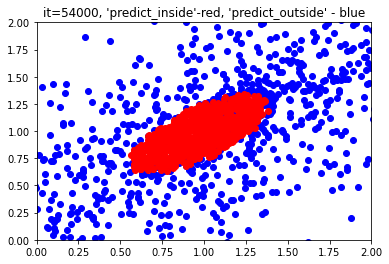

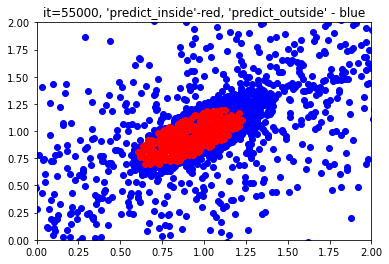

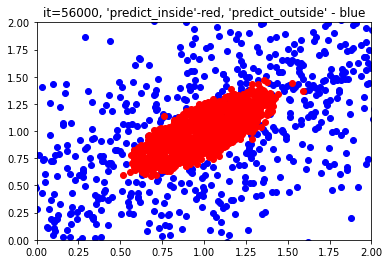

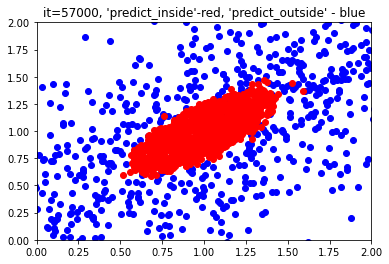

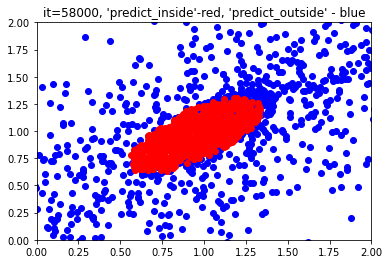

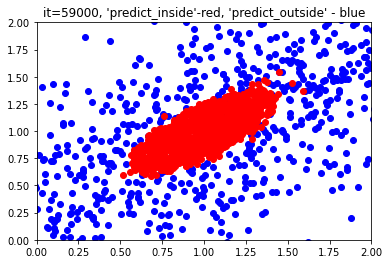

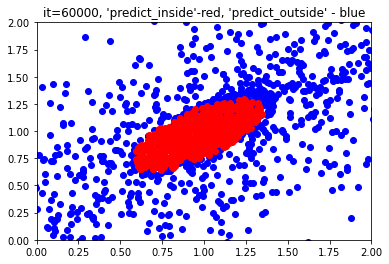

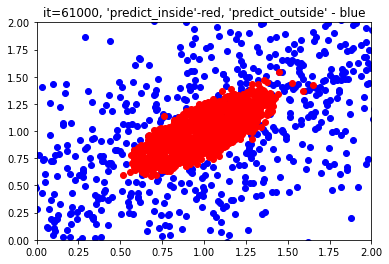

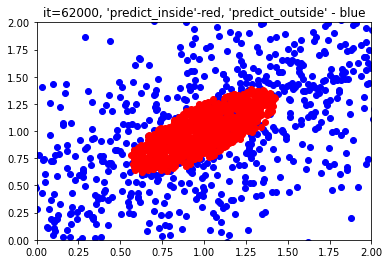

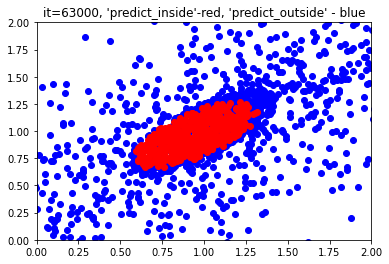

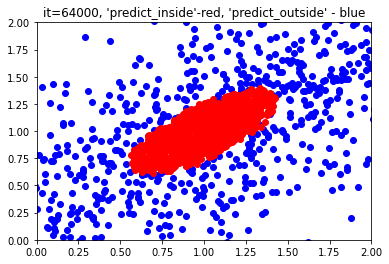

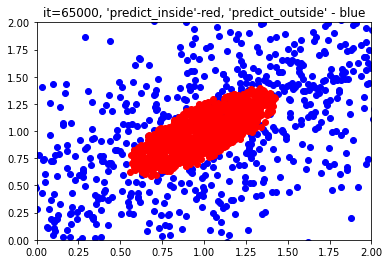

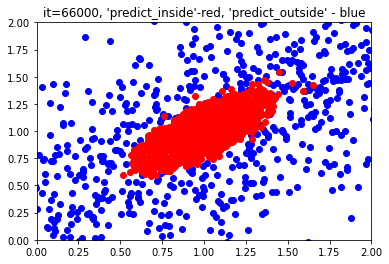

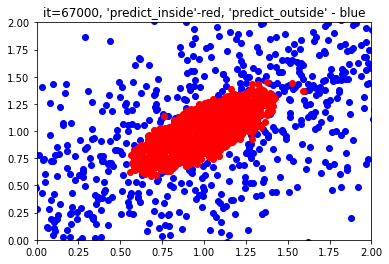

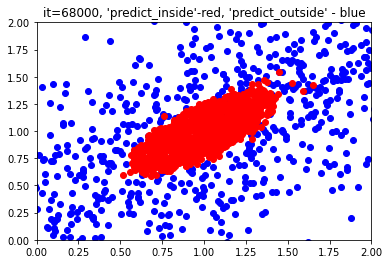

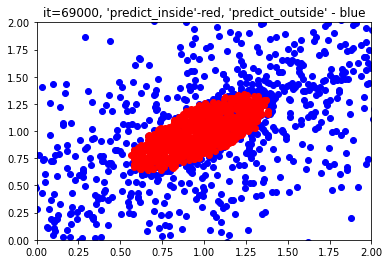

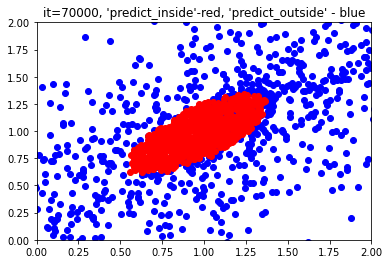

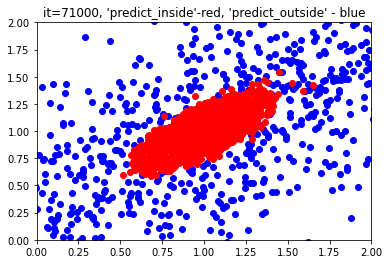

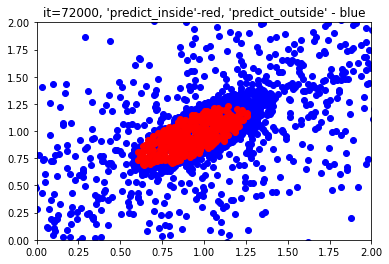

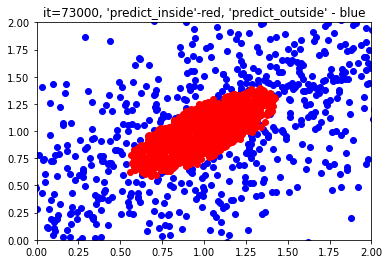

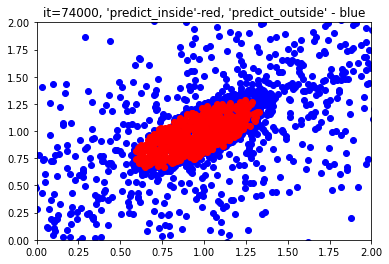

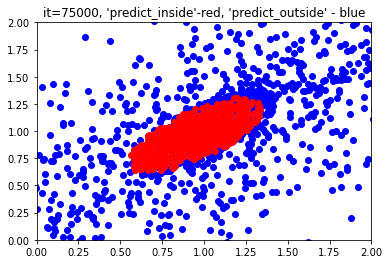

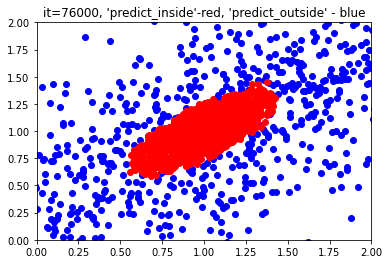

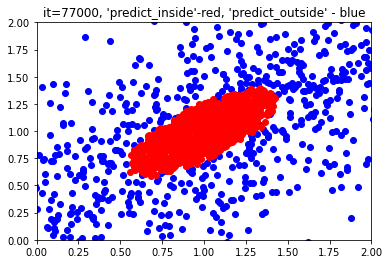

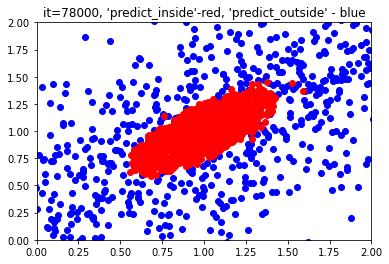

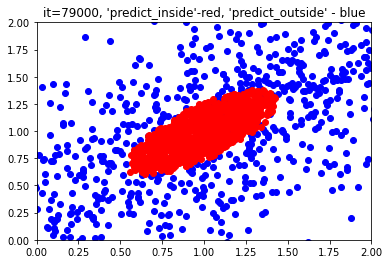

In [11]:
it = 1
while(True):
    percept = (X_second_order.dot(alpha)<=0)
    if(percept.sum()<=1):
        break
    random_index = np.random.choice( np.argwhere(percept).squeeze() )
    #print(random_index)
    random_sample = X_second_order[random_index]
    if(alpha.dot(random_sample)<=0):
        alpha += random_sample
        if(it%10000==0):
            print(f"it={it}, n_wrong = {percept.sum()}")
        if(it%1000==0):
            predict = np.array( [get_coord2order(x).dot(alpha) for x in X ] )
            plt.figure()
            plt.xlim([0,2])
            plt.ylim([0,2])
            plt.title(f"it={it}, 'predict_inside'-red, 'predict_outside' - blue")
            plt.scatter(X[predict>0][:,0], X[predict>0][:,1], color='blue')
            plt.scatter(X[predict<=0][:,0], X[predict<=0][:,1], color='red')
        it+=1

In [12]:
def print_equation(alpha):
    alpha = np.round(alpha, 2)
    a0 = alpha[0]
    ax = alpha[1]
    ay = alpha[2]
    az = alpha[3]
    axx = alpha[4]
    axy = alpha[5]
    axz = alpha[6]
    ayy = alpha[7]
    ayz = alpha[8]
    azz = alpha[9]
    print(f"{a0} + {ax}*x + {ay}*y +{az}*z + {axx}*x^2 + {axy}*xy + {axz}*xz + {ayy}*y^2 + {ayz}*yz + {azz}*z^2 = 0")

print_equation(alpha)

218.14 + 42.2*x + -301.0*y +-228.46*z + 241.76*x^2 + -391.21*xy + -127.05*xz + 310.89*y^2 + 65.14*yz + 144.4*z^2 = 0


Тепер треба по отриманих із персептрона коефіцієнтами, привести рівняння до канонічної форми

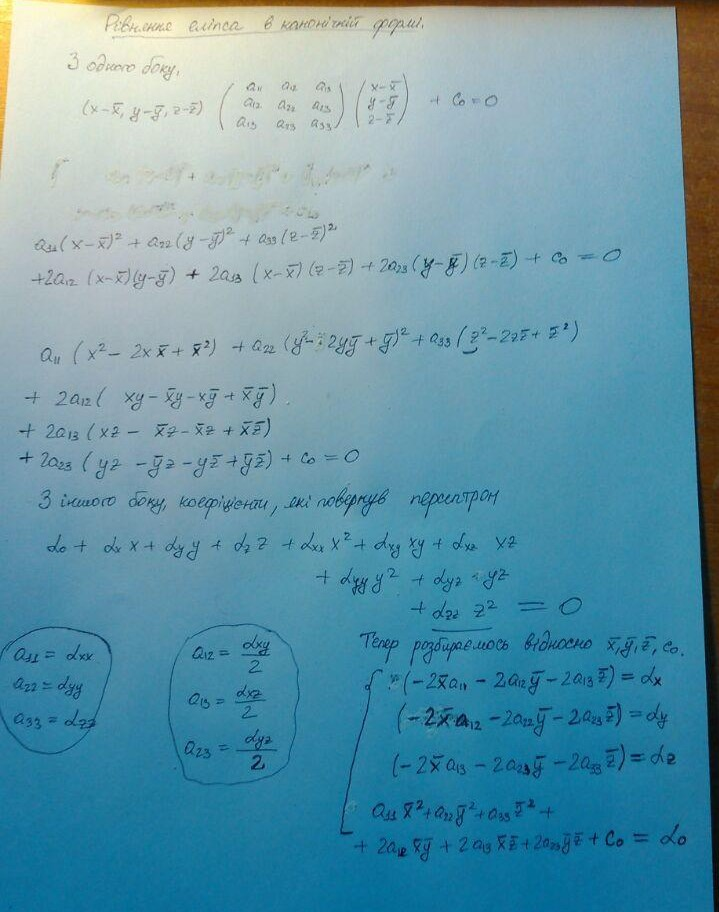

In [13]:
from PIL import Image
Image.open("img1.jpg")

In [14]:
A = np.array([[alpha[4], alpha[5]/2.0, alpha[6]/2.0],[alpha[5]/2.0, alpha[7], alpha[8]/2.0],[alpha[6]/2.0, alpha[8]/2.0, alpha[9]]])
A

array([[ 241.75754121, -195.60296246,  -63.52563567],
       [-195.60296246,  310.8910698 ,   32.57077251],
       [ -63.52563567,   32.57077251,  144.40107797]])

# Оцінка вектора середнього

In [15]:
center = np.linalg.solve(-2*A, alpha[1:4])
center

array([0.98188924, 0.99730923, 0.99808368])

# Істинний вектор середнього

In [16]:
m_mean

array([1., 1., 1.])

In [17]:
c0 = alpha[0] - A.dot(center).dot(center)
c0

-25.24760779787556

# Оцінка коваріаційної матриці

In [18]:
np.linalg.inv(A*d_diam*d_diam/(-c0))

array([[0.99661635, 0.59517109, 0.30419098],
       [0.59517109, 0.70199783, 0.1034896 ],
       [0.30419098, 0.1034896 , 0.83899342]])

# Істинна коваріаційна матриця

In [19]:
S_cov

array([[0.9, 0.6, 0.3],
       [0.6, 0.7, 0.1],
       [0.3, 0.1, 0.8]])

In [20]:
X[0], is_inside[0]

(array([1.14217389, 1.17610476, 0.84242455]), True)

In [21]:
get_coord2order(X[0]).dot(alpha) #inside ellips

-15.453567823578538

In [22]:
X[1000], is_inside[1000]

(array([2.46373352, 2.19219684, 0.50482544]), False)

In [23]:
get_coord2order(X[1000]).dot(alpha) #outside ellips

346.41707550100756